# Image Classification using AWS SageMaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.<br>
Use AWS Sagemaker to train a pretrained model that can perform image classification by using the Sagemaker profiling, debugger, hyperparameter tuning; deploy the trained model and use the endpoint to predict. This is done on the provided dog breed classication data set.<br>

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

In [4]:
# get default s3
session = sagemaker.Session()
bucket = session.default_bucket()

print("Default S3 Bucket: ", bucket)

Default S3 Bucket:  sagemaker-us-east-1-098421563522


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [33]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2023-03-26 00:09:16--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.144
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  48.7MB/s    in 24s     

2023-03-26 00:09:50 (44.1 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [5]:
### data explore
import os
path = "dogImages/train" 
num_files = len(os.listdir(path))
print("Number of class:", num_files)

Number of class: 133


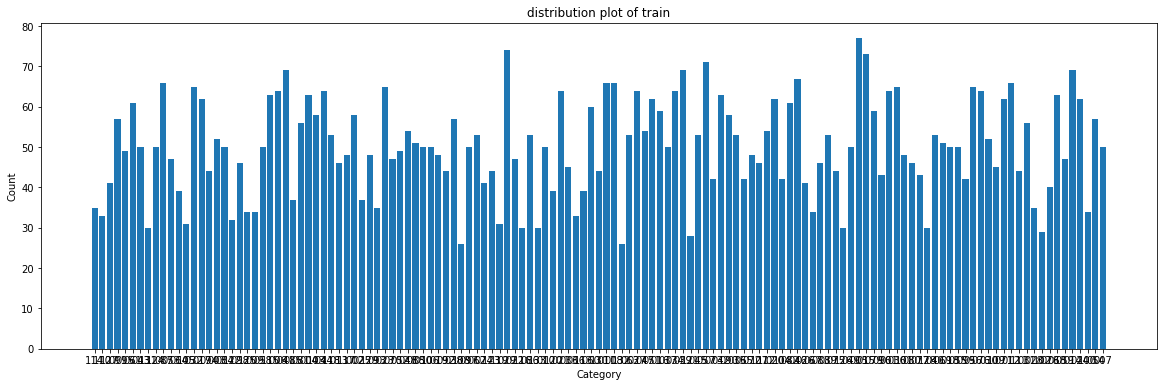

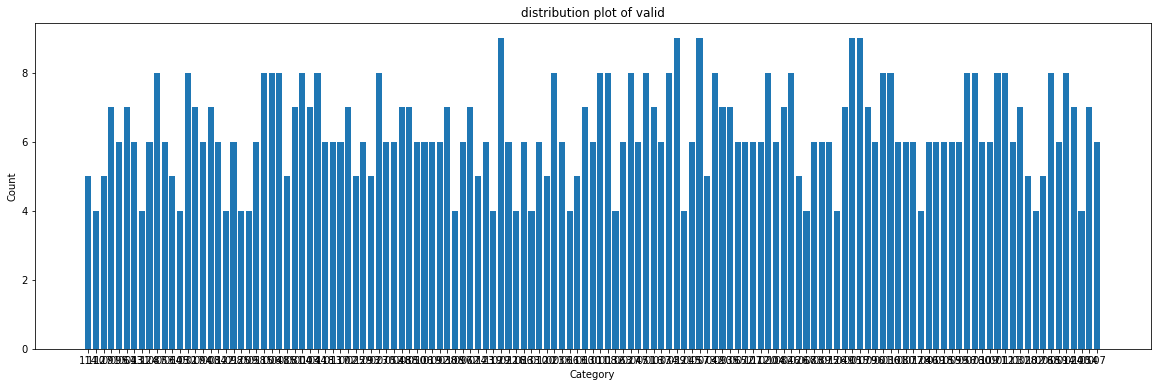

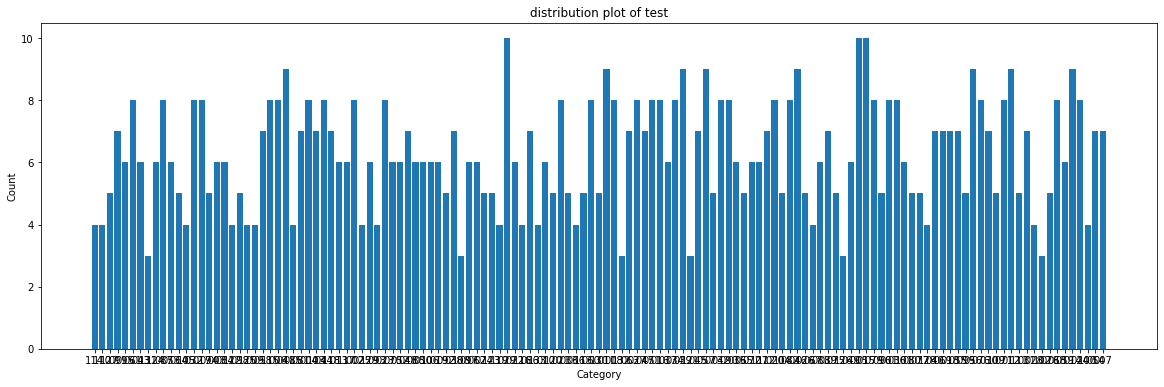

In [6]:
import matplotlib.pyplot as plt
def dist_plot(directory):
    class_dict={}
    path = f'dogImages/{directory}'
    for cate in os.listdir(path):
        cate_path = os.path.join(path,cate)
        cate = cate.split('.')[0]
        class_dict[cate] = len(os.listdir(cate_path))
    plt.figure(figsize=(20,6))
    plt.bar(class_dict.keys(), class_dict.values())
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.title(f"distribution plot of {directory}")
    plt.show()
dist_plot('train')
dist_plot('valid')
dist_plot('test')

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
role = sagemaker.get_execution_role()

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]


In [7]:
#TODO: Create estimators for your HPs
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)# TODO: Your HP tuner here

In [36]:
# TODO: Fit your HP Tuner
data_channels = {"train":f's3://{bucket}/dogImages/train/',
                 "valid":f's3://{bucket}/dogImages/valid/',
                 "test":f's3://{bucket}/dogImages/test/'
                }
tuner.fit(data_channels, wait=True) # TODO: Remember to include your data channels

...........................................................................................................!


In [37]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2023-03-25 15:45:54 Starting - Preparing the instances for training
2023-03-25 15:45:54 Downloading - Downloading input data
2023-03-25 15:45:54 Training - Training image download completed. Training in progress.
2023-03-25 15:45:54 Uploading - Uploading generated training model
2023-03-25 15:45:54 Completed - Resource reused by training job: pytorch-training-230325-1540-003-6f438c4f


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'lr': '0.01289679615484953',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-03-25-15-40-29-116"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-098421563522/pytorch-training-2023-03-25-15-40-29-116/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [11]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    s3_output_path=f's3://{bucket}/output/',
    collection_configs=[
        CollectionConfig(
            name='CrossEntropyLoss_output',
            parameters={'include_regex':'CrossEntropyLoss_output.*',
                        'train.save_interval': '10',
                        'eval.save_interval': '1',
                        'predict.save_interval': '1'
                         })
    ]
)

hyperparameters = {'batch-size': '64','lr': '0.01289679615484953'}

In [12]:
# TODO: Create and fit an estimator
from sagemaker.pytorch import PyTorch
role = sagemaker.get_execution_role()
data_channels = {"train":f's3://{bucket}/dogImages/train/',
                 "valid":f's3://{bucket}/dogImages/valid/',
                 "test":f's3://{bucket}/dogImages/test/'
                }
estimator = PyTorch(
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    entry_point="train_model.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)
 # TODO: Your estimator here
estimator.fit(data_channels,
              wait=True)


2023-03-26 12:23:18 Starting - Starting the training job...
2023-03-26 12:23:45 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
.........
2023-03-26 12:25:16 Downloading - Downloading input data.........
2023-03-26 12:26:45 Training - Downloading the training image...............
2023-03-26 12:29:18 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-26 12:29:18,614 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-26 12:29:18,645 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-03-26 12:29:18,647 sagemaker_pytorch_container.training INFO     Invoking user training 

In [31]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())


print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.PREDICT)))

[2023-03-26 12:59:01.505 pytorch-1-8-gpu-py36-ml-t3-xlarge-c91cf8145f693f34b2ab55c00841:29 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-098421563522/output/pytorch-training-2023-03-26-12-23-17-200/debug-output
[2023-03-26 12:59:02.054 pytorch-1-8-gpu-py36-ml-t3-xlarge-c91cf8145f693f34b2ab55c00841:29 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 235 more expected)', IncompleteRead(0 bytes read, 235 more expected)) while reading s3://sagemaker-us-east-1-098421563522/output/pytorch-training-2023-03-26-12-23-17-200/debug-output/index/000000000/000000000109_worker_0.json . Will retry now
[2023-03-26 12:59:03.637 pytorch-1-8-gpu-py36-ml-t3-xlarge-c91cf8145f693f34b2ab55c00841:29 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-26 12:59:04.656 pytorch-1-8-gpu-py36-ml-t3-xlarge-c91cf8145f693f34b2ab55c00841:29 INFO 

In [32]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


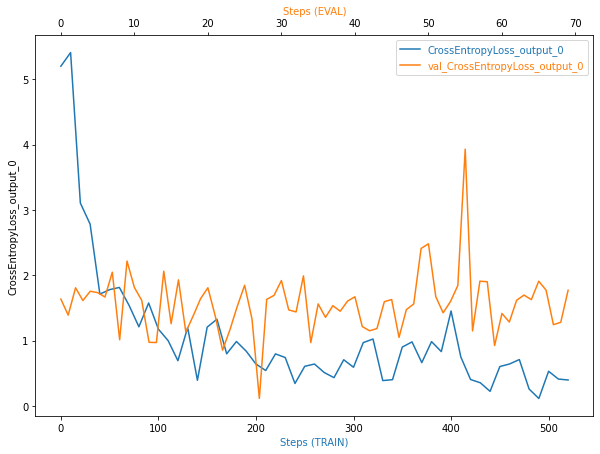

In [33]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it? <br>
<br>
Validation loss goes up at the tail, implying overfitting problem. Maybe need to add dropout layer in the model, or apply data augmentation in the training dataset.


In [34]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-098421563522/pytorch-training-2023-03-26-12-23-17-200/rule-output


In [35]:
! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

2023-03-26 12:37:55     435653 pytorch-training-2023-03-26-12-23-17-200/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-26 12:37:54     294232 pytorch-training-2023-03-26-12-23-17-200/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-26 12:37:49        551 pytorch-training-2023-03-26-12-23-17-200/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-26 12:37:49      28429 pytorch-training-2023-03-26-12-23-17-200/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-26 12:37:49       2168 pytorch-training-2023-03-26-12-23-17-200/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-26 12:37:49        130 pytorch-training-2023-03-26-12-23-17-200/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-03-26 12:37:49        873 pytorch-training-2023-03-26-12-23-17-200/rule-output/ProfilerReport/profiler-output/profiler-re

In [36]:
profiler_report_name = [rule["RuleConfigurationName"] for rule in estimator.latest_training_job.rule_job_summary() 
                        if "Profiler" in rule["RuleConfigurationName"]][0]

In [38]:
import IPython
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [15]:
# TODO: Deploy your model to an endpoint

predictor=estimator.deploy(initial_instance_count=1,instance_type='ml.p3.2xlarge') # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: pytorch-training-2023-03-26-12-39-54-301
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-03-26-12-39-54-301


------------!

In [21]:
# TODO: Run an prediction on the endpoint
from train_model import create_data_loaders
import torch
path = 'dogImages/test/'   
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# predict  4 images in the test set
testloader = create_data_loaders(path,batch_size=4) # TODO: Your code to load and preprocess image to send to endpoint for prediction
inputs, labels = next(iter(testloader)) # only predict the first batch in test loader
inputs = inputs.to(device)
labels = labels.to(device)
response = predictor.predict(inputs)

In [29]:
# get predicted class
import numpy as np
print ("predicted labels for the images are:", list(np.argmax(response, 1)))
print ("true labels for the images are:", list(labels.numpy()))

predicted labels for the images are: [4, 85, 23, 132]
true labels for the images are: [4, 85, 23, 100]


In [30]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-training-2023-03-26-12-39-54-301
INFO:sagemaker:Deleting endpoint with name: pytorch-training-2023-03-26-12-39-54-301
